In this notebook, I develop a Logistic Regression Model to predict the Probability of Default for a Loan applicant.

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, auc)
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample

In [54]:
pd.set_option('display.max_columns', None)

In [55]:
data = pd.read_csv('Loan_default.csv')

Basic information about the Loan Dataset

In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   LoanID          255347 non-null  object 
 1   Age             255347 non-null  int64  
 2   Income          255347 non-null  int64  
 3   LoanAmount      255347 non-null  int64  
 4   CreditScore     255347 non-null  int64  
 5   MonthsEmployed  255347 non-null  int64  
 6   NumCreditLines  255347 non-null  int64  
 7   InterestRate    255347 non-null  float64
 8   LoanTerm        255347 non-null  int64  
 9   DTIRatio        255347 non-null  float64
 10  Education       255347 non-null  object 
 11  EmploymentType  255347 non-null  object 
 12  MaritalStatus   255347 non-null  object 
 13  HasMortgage     255347 non-null  object 
 14  HasDependents   255347 non-null  object 
 15  LoanPurpose     255347 non-null  object 
 16  HasCoSigner     255347 non-null  object 
 17  Default   

In [57]:
data.head()

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


In [58]:
data=data.drop(['LoanID'],axis=1)

Checking for Null values and duplicates

In [59]:
data.isna().sum()

Age               0
Income            0
LoanAmount        0
CreditScore       0
MonthsEmployed    0
NumCreditLines    0
InterestRate      0
LoanTerm          0
DTIRatio          0
Education         0
EmploymentType    0
MaritalStatus     0
HasMortgage       0
HasDependents     0
LoanPurpose       0
HasCoSigner       0
Default           0
dtype: int64

In [60]:
data.duplicated().sum()

0

Checking for outliers. We observe no outliers.

In [61]:
data.columns

Index(['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed',
       'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio', 'Education',
       'EmploymentType', 'MaritalStatus', 'HasMortgage', 'HasDependents',
       'LoanPurpose', 'HasCoSigner', 'Default'],
      dtype='object')

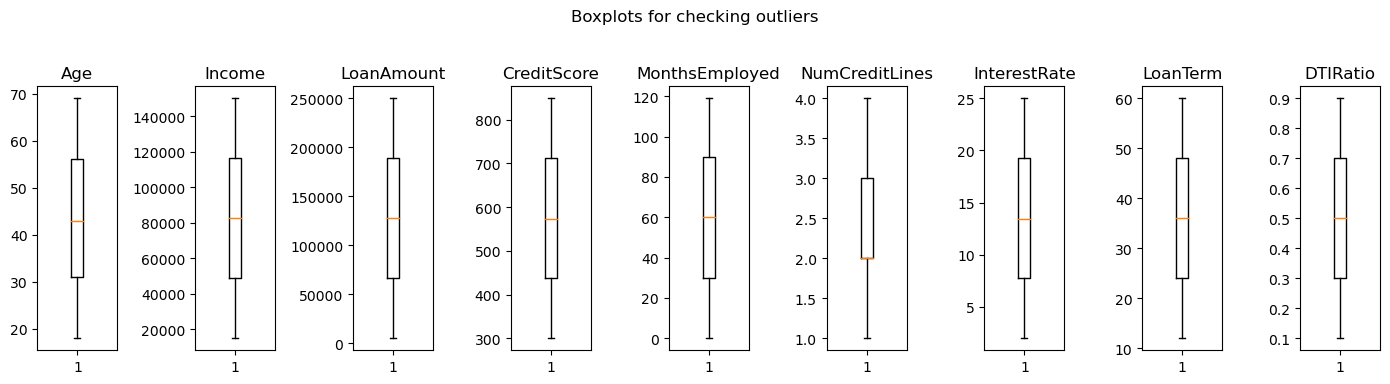

In [62]:
boxplot_labels=['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed',
       'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio']
fig, axs = plt.subplots(1, len(boxplot_labels), figsize=(14, 4), sharey=False)

for i, col in enumerate(boxplot_labels):
    axs[i].boxplot(data[col])
    axs[i].set_title(col)

plt.suptitle("Boxplots for checking outliers")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Checking for the class imbalance. Let us remove the imbalance by downsampling the majority class. 

In [63]:
data["Default"].value_counts(normalize=True)

Default
0    0.883872
1    0.116128
Name: proportion, dtype: float64

In [64]:
data["Default"].value_counts()

Default
0    225694
1     29653
Name: count, dtype: int64

In [65]:
data_majority = data[data["Default"] == 0]
data_minority = data[data["Default"] == 1]

data_majority_downsampled = resample(data_majority, replace=False, n_samples=len(data_minority), random_state=0)               
data_downsampled = pd.concat([data_minority, data_majority_downsampled]).reset_index(drop=True)
data_downsampled["Default"].value_counts()

Default
1    29653
0    29653
Name: count, dtype: int64

Checking for correlations among the various numerical features.

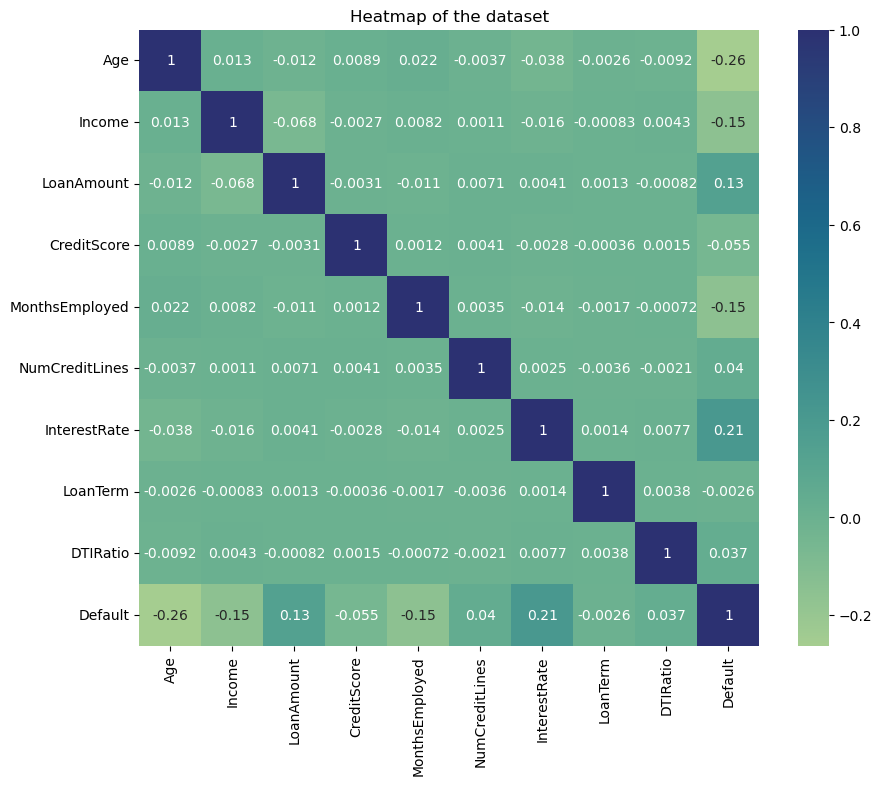

In [66]:
plt.figure(figsize=(10, 8))
sns.heatmap(data_downsampled.corr(numeric_only=True), 
            annot=True, cmap="crest")
plt.title("Heatmap of the dataset")
plt.show()

Convert the categorical features from string to numeric using One Hot Encoder 

In [67]:
data_to_encode = data_downsampled[["Education", "EmploymentType", "MaritalStatus", "HasMortgage", "HasDependents", "LoanPurpose", "HasCoSigner"]]
data_to_encode.head()

,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner
0,Master's,Unemployed,Divorced,Yes,Yes,Auto,No
1,High School,Unemployed,Single,Yes,No,Business,Yes
2,Bachelor's,Self-employed,Divorced,Yes,No,Education,No
3,PhD,Full-time,Divorced,No,No,Education,Yes
4,Bachelor's,Self-employed,Divorced,Yes,No,Education,No


In [68]:
encoder = OneHotEncoder(drop='first', sparse_output=False)

In [69]:
data_encoded = encoder.fit_transform(data_to_encode)

In [70]:
encoder.get_feature_names_out()

array(['Education_High School', "Education_Master's", 'Education_PhD',
       'EmploymentType_Part-time', 'EmploymentType_Self-employed',
       'EmploymentType_Unemployed', 'MaritalStatus_Married',
       'MaritalStatus_Single', 'HasMortgage_Yes', 'HasDependents_Yes',
       'LoanPurpose_Business', 'LoanPurpose_Education',
       'LoanPurpose_Home', 'LoanPurpose_Other', 'HasCoSigner_Yes'],
      dtype=object)

In [71]:
data_encoded_df = pd.DataFrame(data=data_encoded, columns=encoder.get_feature_names_out())
data_encoded_df.head()

,Education_High School,Education_Master's,Education_PhD,EmploymentType_Part-time,EmploymentType_Self-employed,EmploymentType_Unemployed,MaritalStatus_Married,MaritalStatus_Single,HasMortgage_Yes,HasDependents_Yes,LoanPurpose_Business,LoanPurpose_Education,LoanPurpose_Home,LoanPurpose_Other,HasCoSigner_Yes
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [72]:
data_downsampled.drop(columns=["Education", "EmploymentType", "MaritalStatus", "HasMortgage", "HasDependents", "LoanPurpose", "HasCoSigner"]).head()

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Default
0,46,84208,129188,451,26,3,21.17,24,0.31,1
1,25,90298,90448,720,18,2,22.72,24,0.10,1
2,36,42053,92357,827,83,1,23.94,48,0.20,1
3,28,149227,139759,375,56,3,5.84,36,0.80,1
4,19,40718,78515,319,119,2,14.00,24,0.17,1


In [73]:
data_df = pd.concat([data_downsampled.drop(columns=["Education", "EmploymentType", "MaritalStatus", "HasMortgage", "HasDependents", "LoanPurpose", "HasCoSigner"]).reset_index(drop=True), data_encoded_df], axis=1)
data_df.head()

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Default,Education_High School,Education_Master's,Education_PhD,EmploymentType_Part-time,EmploymentType_Self-employed,EmploymentType_Unemployed,MaritalStatus_Married,MaritalStatus_Single,HasMortgage_Yes,HasDependents_Yes,LoanPurpose_Business,LoanPurpose_Education,LoanPurpose_Home,LoanPurpose_Other,HasCoSigner_Yes
0,46,84208,129188,451,26,3,21.17,24,0.31,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,25,90298,90448,720,18,2,22.72,24,0.10,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2,36,42053,92357,827,83,1,23.94,48,0.20,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,28,149227,139759,375,56,3,5.84,36,0.80,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,19,40718,78515,319,119,2,14.00,24,0.17,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


Separate the dataset into Features and Target variable

In [74]:
y = data_df["Default"]

In [75]:
X = data_df.drop(["Default"],axis=1)
X.head()

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education_High School,Education_Master's,Education_PhD,EmploymentType_Part-time,EmploymentType_Self-employed,EmploymentType_Unemployed,MaritalStatus_Married,MaritalStatus_Single,HasMortgage_Yes,HasDependents_Yes,LoanPurpose_Business,LoanPurpose_Education,LoanPurpose_Home,LoanPurpose_Other,HasCoSigner_Yes
0,46,84208,129188,451,26,3,21.17,24,0.31,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,25,90298,90448,720,18,2,22.72,24,0.10,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2,36,42053,92357,827,83,1,23.94,48,0.20,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,28,149227,139759,375,56,3,5.84,36,0.80,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,19,40718,78515,319,119,2,14.00,24,0.17,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


Perform the Train-Test split (75% - 25%)

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [77]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((44479, 24), (14827, 24), (44479,), (14827,))

Fit Logistic Regression model to Training data. Check the performance on the Test data by displaying the Confusion matrix and various scores.

In [78]:
log_clf = LogisticRegression(random_state=0, max_iter=1000).fit(X_train, y_train)

In [79]:
y_pred = log_clf.predict(X_test)

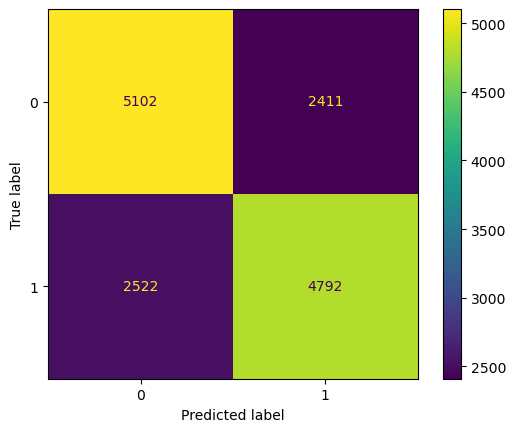

In [80]:
log_cm = confusion_matrix(y_test, y_pred, labels=log_clf.classes_)
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=log_clf.classes_)
log_disp.plot()
plt.show()

In [81]:
target_labels = ["Default", "No Default"]
print(classification_report(y_test, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

     Default       0.67      0.68      0.67      7513
  No Default       0.67      0.66      0.66      7314

    accuracy                           0.67     14827
   macro avg       0.67      0.67      0.67     14827
weighted avg       0.67      0.67      0.67     14827



Review the importance of each Feature by finding the model coefficients.

In [82]:
coef=pd.DataFrame(data={"Feature Name":log_clf.feature_names_in_, "Model Coefficient":log_clf.coef_[0]})
coef.sort_values(by=['Model Coefficient'])

,Feature Name,Model Coefficient
0,Age,-0.032096
4,MonthsEmployed,-0.007919
23,HasCoSigner_Yes,-0.001164
18,HasDependents_Yes,-0.000931
15,MaritalStatus_Married,-0.000594
21,LoanPurpose_Home,-0.000553
17,HasMortgage_Yes,-0.000285
11,Education_PhD,-0.000280
10,Education_Master's,-0.000190
1,Income,-0.000006


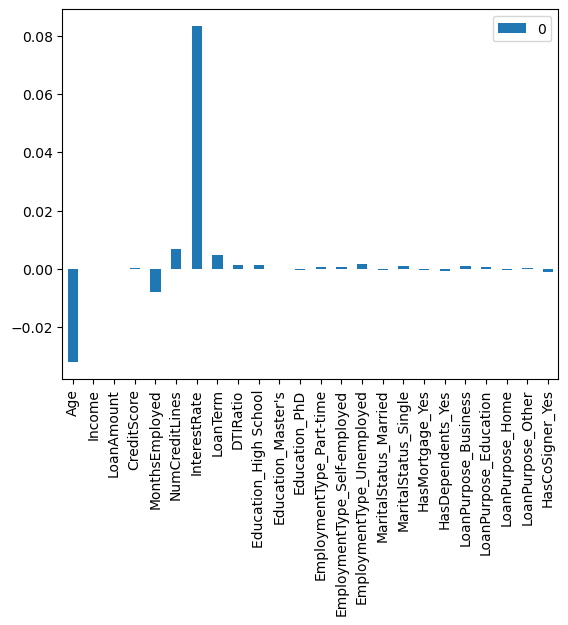

In [83]:
daf = pd.DataFrame(list(coef['Model Coefficient']),index=list(coef['Feature Name']))
plot = daf.plot(kind='bar')

Plot the ROC curve

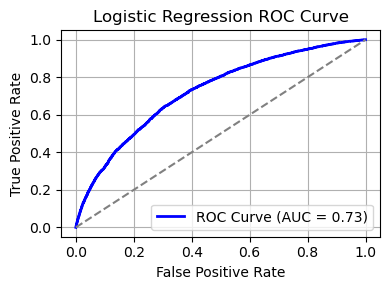

In [84]:
y_pred_proba = log_clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()